In [1]:
import os
import json
import warnings
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict
warnings.filterwarnings("ignore")

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.family'] = 'DeJavu Serif'

In [2]:
abbre2model = {'Gemma-2B':'gemma-2-2b-it', 'Gemma-9B':'gemma-2-9b-it', 'Gemma-27B':'gemma-2-27b-it', 
               'Llama-3B':'Llama-3.2-3B-Instruct', 'Llama-8B':'Llama-3.1-8B-Instruct', 'Llama-70B':'Llama-3.3-70B-Instruct', 
               'Qwen-3B':'Qwen2.5-3B-Instruct', 'Qwen-7B':'Qwen2.5-7B-Instruct', 'Qwen-14B':'Qwen2.5-14B-Instruct'}
statuses = ['Consistent Correct', 'Conflicting Correct', 'Absent', 'Conflicting Wrong', 'Consistent Wrong']
settings = [
    'Parametric Knowledge\n(Multi-Choice Setting,\nNo Context)',
    'Contextual Knowledge\n(Multi-Choice Setting,\nGold Context)',
    'Contextual Knowledge\n(Multi-Choice Setting,\nNoisy Context)',
    'Parametric Knowledge\n(Open-Ended Setting,\nNo Context)',
    'Contextual Knowledge\n(Open-Ended Setting,\nGold Context)',
]
setting2freq = {}

In [ ]:
def find_status(answer, modes):
    if len(modes) == num_opt: return 'Absent'
    if len(modes) == 1:
        if modes[0] == answer: return 'Consistent Correct'
        else: return 'Consistent Wrong'
    if answer in modes: return 'Conflicting Correct'
    else: return 'Conflicting Wrong'

num_opt = 3
dataset = pd.read_csv('Data/Input/HotpotQA.csv')
size = len(dataset)
idx2answer = {idx:answer for idx, answer in enumerate(dataset['answer'])}
find_status_all = lambda file, key: [find_status(idx2answer[idx], file[str(idx)][key]) for idx in range(len(file))]

cat2freq = defaultdict(list)
for abbre, model in abbre2model.items():
    mcq = json.load(open(f'Data/Status/HotpotQA/{model}.json'))
    for cat in ['memory', 'context']:
        freq = Counter(find_status_all(mcq, cat))
        cat2freq[cat].append([freq[status] for status in statuses])
setting2freq['Parametric Knowledge (Multi-Choice Setting, No Context)'] = np.stack(cat2freq['memory']) / size * 100
setting2freq['Contextual Knowledge (Multi-Choice Setting, Gold Context)'] = np.stack(cat2freq['context']) / size * 100

noisy2freq = []
for abbre, model in abbre2model.items():
    path = f'Data/Rebuttal/Noisy/{model}_status.json'
    noisy = json.load(open(path))
    freq = Counter(find_status_all(noisy, 'context'))
    noisy2freq.append([freq[status] for status in statuses])
setting2freq['Contextual Knowledge (Multi-Choice Setting, Noisy Context)'] = np.stack(noisy2freq) / size * 100

openend2freq = defaultdict(list)
for abbre, model in abbre2model.items():
    path = f'Data/Rebuttal/Open/{model}_status.json'
    openend = json.load(open(path))
    for cat in ['memory', 'context']:
        freq = Counter([openend[str(idx)][cat] for idx in range(len(openend))])
        openend2freq[cat].append([freq[status] for status in statuses])
setting2freq['Parametric Knowledge (Open-Ended Setting, No Context)'] = np.stack(openend2freq['memory']) / size * 100
setting2freq['Contextual Knowledge (Open-Ended Setting, Gold Context)'] = np.stack(openend2freq['context']) / size * 100

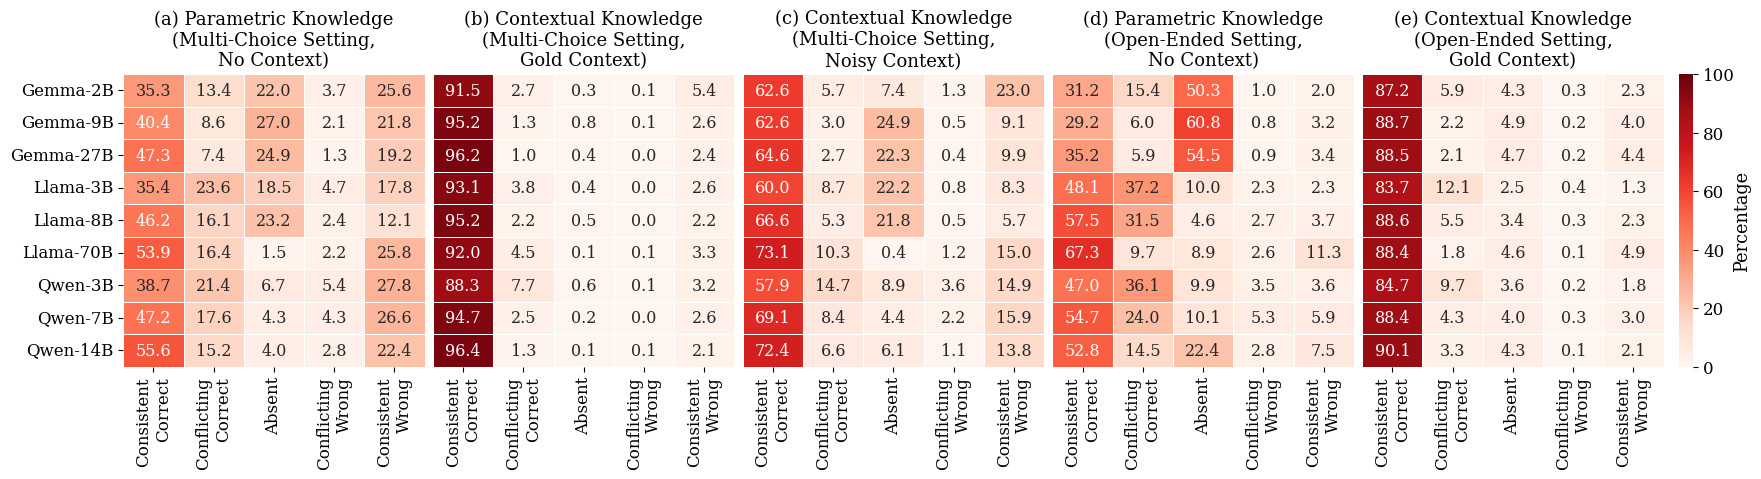

In [ ]:
fontsize = 12
vmin, vmax = 0, 100
num_col, num_row = 5, 1
sub_col, sub_row = len(statuses), len(abbre2model)
size_col, size_row = 0.7, 0.52

fig, axs = plt.subplots(num_row, num_col, figsize=(num_col*sub_col*size_col, num_row*sub_row*size_row), constrained_layout=True)

xticklabels = ['Consistent\nCorrect', 'Conflicting\nCorrect', 'Absent', 'Conflicting\nWrong', 'Consistent\nWrong']

for sid, setting in enumerate(settings):
    sns.heatmap(setting2freq[setting.replace('\n', ' ')], ax=axs[sid], linewidth=0.5, vmin=vmin, vmax=vmax,
                yticklabels=sid==0, annot=True, fmt=".1f", annot_kws={'fontsize':fontsize-0.5},
                cmap="Reds", cbar=sid==len(setting2freq)-1, cbar_kws={'label':'Percentage'})
    axs[sid].set_title(f'({chr(ord("a")+sid)}) ' + setting, fontsize=fontsize+1)
    axs[sid].set_xticklabels(xticklabels, fontsize=fontsize, ha='right', va='center', rotation=90, rotation_mode="anchor")
axs[0].set_yticklabels(abbre2model.keys(), rotation=0, ha='right', va='center', fontsize=fontsize)
cbar = axs[-1].collections[0].colorbar
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.yaxis.label.set_size(fontsize+0.75)
cbar.ax.yaxis.labelpad = -1

plt.savefig('Figure/status_other.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

In [ ]:
def find_status(answer, modes):
    if len(modes) == num_opt: return 'Absent'
    if len(modes) == 1:
        if modes[0] == answer: return 'Consistent Correct'
        else: return 'Consistent Wrong'
    if answer in modes: return 'Conflicting Correct'
    else: return 'Conflicting Wrong'

num_opt = 3
dataset = pd.read_csv('Data/Input/HotpotQA.csv')
size = len(dataset)
idx2answer = {idx:answer for idx, answer in enumerate(dataset['answer'])}
find_status_all = lambda file, key: [find_status(idx2answer[idx], file[str(idx)][key]) for idx in range(len(file))]

abbre2transition_noisy = {abbre: np.zeros((len(statuses), len(statuses))) for abbre in abbre2model.keys()}
for abbre, model in abbre2model.items():
    mcq = json.load(open(f'Data/Status/HotpotQA/{model}.json'))
    cat2status = {'memory': find_status_all(mcq, 'memory')}

    path = f'Data/Rebuttal/Noisy/{model}_status.json'
    noisy = json.load(open(path))
    cat2status['context'] = find_status_all(noisy, 'context')
    cat2status = pd.DataFrame(cat2status)
    status_freq = cat2status['memory'].value_counts().to_dict()
    transition_freq = cat2status.groupby(['memory', 'context']).size().to_dict()

    for i, status1 in enumerate(statuses):
        if status1 in status_freq:
            for j, status2 in enumerate(statuses):
                if (status1, status2) in transition_freq:
                    abbre2transition_noisy[abbre][i, j] = transition_freq[(status1, status2)] / status_freq[status1] * 100

abbre2transition_open = {abbre: np.zeros((len(statuses), len(statuses))) for abbre in abbre2model.keys()}
for abbre, model in abbre2model.items():
    path = f'Data/Rebuttal/Open/{model}_status.json'
    openend = json.load(open(path))
    cat2status = pd.DataFrame.from_dict(openend, orient='index')
    status_freq = cat2status['memory'].value_counts().to_dict()
    transition_freq = cat2status.groupby(['memory', 'context']).size().to_dict()

    for i, status1 in enumerate(statuses):
        if status1 in status_freq:
            for j, status2 in enumerate(statuses):
                if (status1, status2) in transition_freq:
                    abbre2transition_open[abbre][i, j] = transition_freq[(status1, status2)] / status_freq[status1] * 100

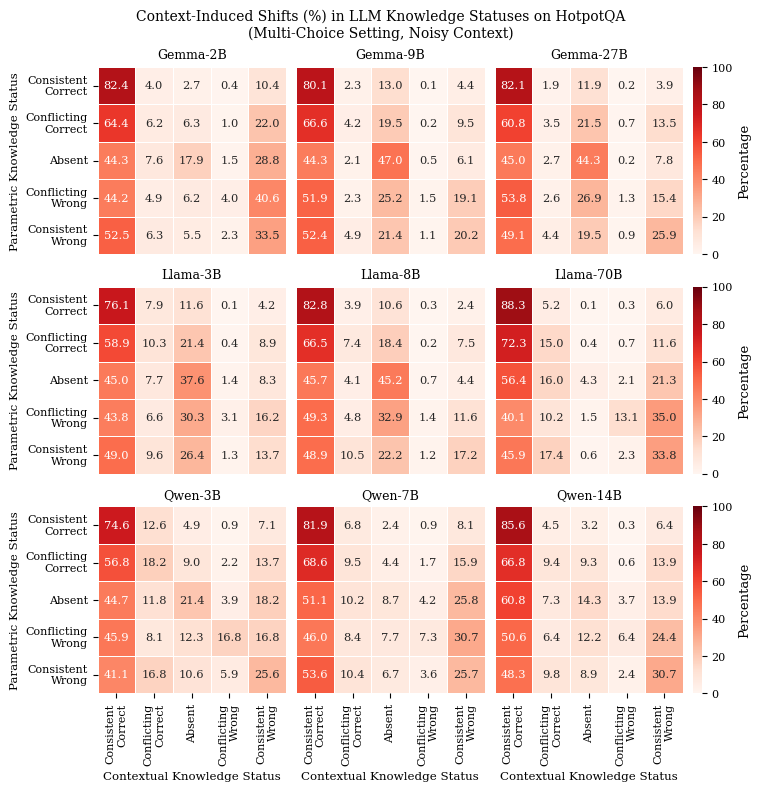

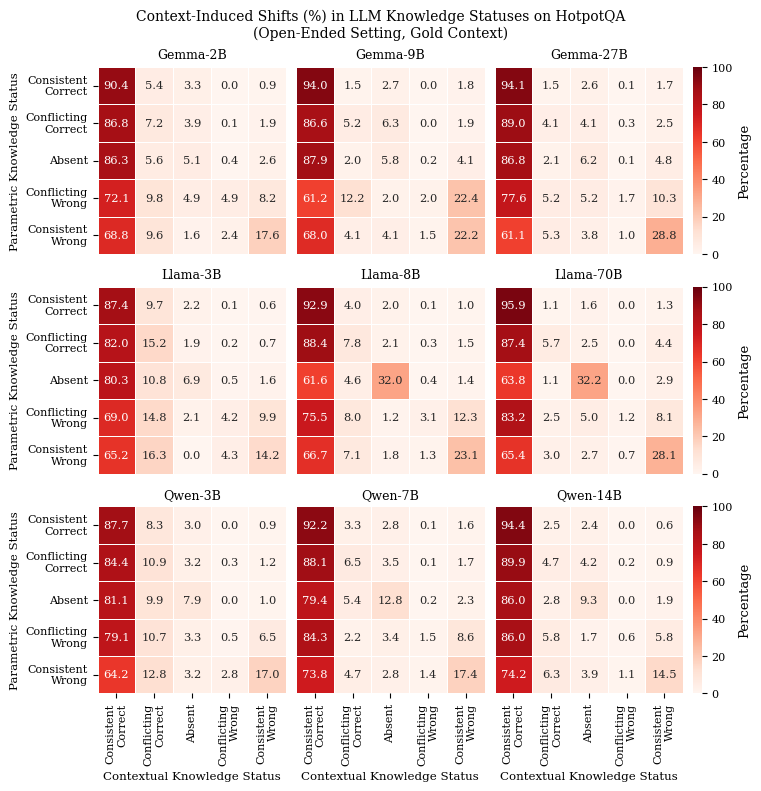

In [ ]:
def draw_switch(abbre2transition, setting):
    fontsize = 10 # 11.5
    vmin, vmax = 0, 100
    num_col, num_row = 3, 3
    sub_col, sub_row = len(statuses), len(statuses)
    size_col, size_row = 0.5, 0.52 # 0.65, 0.65
    fig, axs = plt.subplots(num_row, num_col, constrained_layout=True, gridspec_kw={'wspace':0.04, 'hspace':0.01},
                            figsize=(num_col*sub_col*size_col, num_row*sub_row*size_row))

    for idx, model in enumerate(abbre2model):
        idx_r, idx_c = idx//num_col, idx%num_col
        sns.heatmap(abbre2transition[model], 
                    ax=axs[idx_r][idx_c], linewidth=0.5, vmin=vmin, vmax=vmax, 
                    yticklabels=idx_c==0, xticklabels=idx_r==num_row-1, 
                    annot=True, fmt=".1f", annot_kws={'fontsize':fontsize-1.75}, 
                    cmap="Reds", cbar=idx_c==num_col-1, cbar_kws={'label':'Percentage'})
        axs[idx_r][idx_c].set_title(model, fontsize=fontsize-1)

        if idx_r == num_row-1:
            axs[idx_r][idx_c].set_xlabel('Contextual Knowledge Status', fontsize=fontsize-1.5)
            axs[idx_r][idx_c].set_xticklabels(['\n'.join(c.split(' ')) for c in statuses], rotation=90, ha='right', 
                                              va='center', rotation_mode='anchor', fontsize=fontsize-2)

        if idx_c == 0:
            axs[idx_r][idx_c].set_ylabel('Parametric Knowledge Status', fontsize=fontsize-1.5)
            axs[idx_r][idx_c].set_yticklabels(['\n'.join(c.split(' ')) for c in statuses], rotation=0, ha='right', 
                                              va='center', fontsize=fontsize-2)

        if idx_c == num_col-1:
            cbar = axs[idx_r][idx_c].collections[0].colorbar
            cbar.ax.tick_params(labelsize=fontsize-2)
            cbar.ax.yaxis.label.set_size(fontsize-0.5)

    fig.suptitle(setting2title[setting], fontsize=fontsize)
    plt.savefig(f'Figure/switch_{setting}.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)


setting2title = {
    'noisy': 'Context-Induced Shifts (%) in LLM Knowledge Statuses on HotpotQA\n(Multi-Choice Setting, Noisy Context)',
    'open': 'Context-Induced Shifts (%) in LLM Knowledge Statuses on HotpotQA\n(Open-Ended Setting, Gold Context)'
}

draw_switch(abbre2transition_noisy, 'noisy')
draw_switch(abbre2transition_open, 'open')